#  Aztec Summary Report
## Initial Investigation of Censorship Impact

**Date:** May 7, 2024

## Overview of Work

This is a v1 report, prepared in response to the request for information regarding the impact of L1 censorship on the design parameters of the block production phase durations. 

To answer this question, we have focused on a simplified version of our current modeling efforts. Although we make the trade-off of detail for clarity, the assumptions are based in analysis of an extensive data set of actual blocks from the Ethereum blockchain. 

## Model Assumptions

Any model must make simplifying assumptions. The model in use for the current analysis makes the following assumptions in its logic and execution:

* Agents are always *willing* to act. They make no economic considerations with regards to cost or profit. 
    * As time spent in a particular phase progresses, the probability that an agent will take the indicated action increases towards 1.0.
* If the process enters Race Mode, a valid block may still be produced through it.  
* There are no censoring validators.
* Censoring Builders are pre-set from information of current censorship assumptions. Specifically, we construct a set of "censoring builders", and fill it with builders indicated as severely censoring by censorship.pics 
* Events, such as a builder censoring, are independent (as opposed to them censoring strategically, by then bidding higher on the following slot)

This last assumption in particular deserves further exploration, particularly in light of preliminary data analysis below. 


## Simulation Parameters

* `N_timesteps`: 500 simulation timesteps (which can be more than double that in L1 blocks simulated) per trajectory
* `N_samples:` 3 Monte Carlo Runs per parameter combination


The simulation sweeps over all possible combinations of parameter values, as indicated in the following table.

As noted in the table, we set a `fixed_duration` - a.k.a. the phase cannot end early (`dynamical_duration`), but instead goes through the entire duration every time, by setting the minimum duration equal to the maximum duration. 

| Parameter Name  | Values Swept    |
|--------------------------------------|-----------------|
| `phase_duration_proposal_min_blocks` | [0, 3] |
| `phase_duration_proposal_max_blocks` | [3, 12]|
| `phase_duration_reveal_min_blocks`   | [0, `phase_duration_reveal_min_blocks`]  |
| `phase_duration_reveal_max_blocks`   | [3, 24] |
| `phase_duration_commit_bond_min_blocks` | [0, `phase_duration_commit_bond_max_blocks`] |
| `phase_duration_commit_bond_max_blocks` | [3, 12] |
| `phase_duration_rollup_min_blocks`      | [0, `phase_duration_rollup_max_blocks`] |
| `phase_duration_rollup_max_blocks`      | [15, 80] |
----------------------------------------------------------

# Censorship Empirical Data

Courtesy of Toni, we use his dataset on builders, validators and mevboost to construct a censorship series.
Specifically, we have been provided with an updated dataset going from the Merge until April 25th.
To increase relevance, we further dropped all blocks before the Dencun hardfork.

With this set, we can construct a timeseries. This timeseries is initially constructed with 'False' for each timestep. By picking a starting block_number from the dataset, we can then set values to 'True' whenever a priorly indicated censoring builder has a slot. This gives as a snapshot of the empirical data, which lets us evaluate quickly whether a simulation timestep is 'censored', disallowing any agent (except for the current L1 builder) to make an L1 transaction. 

Picking a starting block_number is a bit of an art itself - as an example, we could have picked different start times for every simulation run. This would have let us run over every possible series. However, this would make the results less robust, as we would compare different paramater values over different environments. 

Instead, we choose to test a starting time for every parameter value. This leaves results more robust. 
We do this by including starting times as a sweep parameter, building cartesian products with them.
To pick starting times, we go with a hybrid approach.
On one hand, the goal of this analysis is to start from stringend censorship assumptions - quasi worst case. 
To emulate that, we are hand-picking some of the start times by choosing time series that include long consecutive runs of slots in a row by the same, main censoring builder: Beaverbuild

While handpicking makes up about 20% of our starting times, we Sobol Sample the remaining ones. 

Future iterations might relax the set of censoring builders, or test incomplete censoring (such as increasing gas price), or introduce strategic censoring. Similarly, we might test different time series (such as before Dencun), sample all series randomly, etc. 

## KPIs

A KPI helps us assess whether simulation trajectories score better or worse on our goals. As trajectories vary in the underlying parameters (such as different phase durations, or block rewards) we can use them to identify parameter combinations that score better on our overall goals. These can be seen in `metrics.py`

- `proportion_race_mode`: This measures the proportion of race_mode to total blocks.
- `proportion_skipped` : This measures the proportion of blocks that were skipped (no proposals, or no finalized proof).

## Code and Data Imports 

In [1]:
import seaborn as sns
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import sys
sys.path.append('../')

from IPython.core.getipython import get_ipython

pio.renderers.default = "png"

## Brief Data Exploration

Restricting the data set to only slots since the Dencun event, it is possible to observe the proportion of blocks for each builder. 

Key Insights:
* The largest builder is `beaverbuild.org`
* The full list of censoring builders accounts for 60% of blocks built since Dencun, both over the entire time range and the last 1000 blocks. 
* The time series of censoring builders shows autocorrelation, which deserves further study and may suggest modifying our assumptions of independence. 

In [2]:
DENCUN_BLOCK_NUMBER = 19426589

local_path = '../data/auxiliary/eth_builder_validator_data_cleaned.parquet.gz'
if os.path.isfile(local_path):
    print("Reading data from local computer. ")
    data = pd.read_parquet(
        local_path).query(f"block_number > {DENCUN_BLOCK_NUMBER}")
else:
    print("Reading data from S3 cloud.")
    data = pd.read_parquet(
        's3://aztec-gddt/aux-data/eth_builder_validator_data_cleaned.parquet.gz').query(f"block_number > {DENCUN_BLOCK_NUMBER}")

Reading data from local computer. 


In [3]:
DENCUN_BLOCK_NUMBER = 19426589

data_to_use = data.query(f"block_number > {DENCUN_BLOCK_NUMBER}")


# We pick a set of builders assumed to be censoring, in this case choosing the 15 largest builders denoted as strictly censoring through Toni's analysis. 

CENSORING_BUILDERS = ['beaverbuild.org',
                      'rsync-builder.xyz', 
                      'Flashbots', 
                      'BuildAI (https://buildai.net)', 
                      'Gambit Labs',
                      'boba-builder.com',
                      'Builder + www.btcs.com',
                      'builder0x69',
                      '0x83bee517',
                      'BloXroute',
                      'I can haz block',
                      'EigenPhi',
                      'Edennetwork',
                      'blockbeelder'
                     ]

data_to_use.loc[:, 'is_builder_censor'] = data_to_use['builder'].apply(lambda x: int(x in CENSORING_BUILDERS))

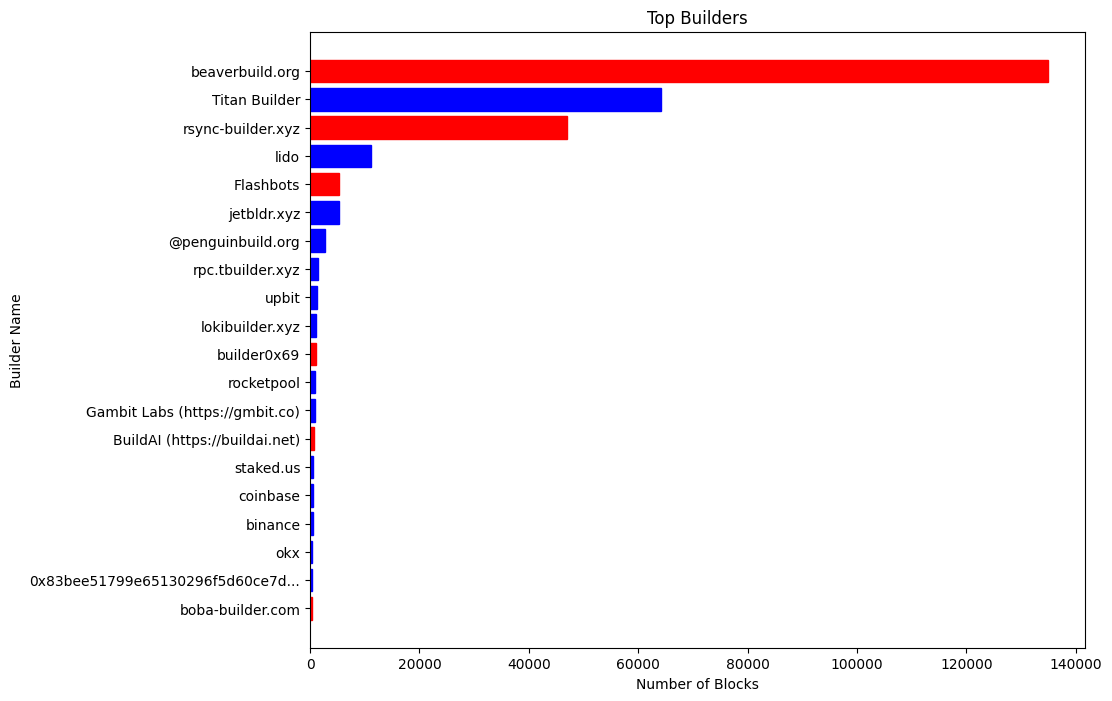

In [4]:
# Plot for top builders

# Number of top entries you want to display
NUM_TOP_ENTRIES = 20

# Character length of name, for readability
MAX_CHAR_LEN = 30

# Calculating the count of each unique value
counts = data_to_use['builder'].value_counts()

# Selecting the top N entries
top_n = counts.nlargest(NUM_TOP_ENTRIES)

# Creating a horizontal bar plot
plt.figure(figsize=(10, 8))
bars = plt.barh(top_n.index, top_n.values)

# Color bars based on whether the builder is in the censoring list
for bar, builder in zip(bars, top_n.index):
    if builder in CENSORING_BUILDERS:
        bar.set_color('red')  # Color for censoring builders
    else:
        bar.set_color('blue')  # Color for non-censoring builders


labels = [label[:MAX_CHAR_LEN] + '...'
         if len(label) > MAX_CHAR_LEN 
         else label 
         for label in top_n.index]

plt.xlabel('Number of Blocks')
plt.ylabel('Builder Name')
plt.yticks(ticks = range(NUM_TOP_ENTRIES), labels=labels)
plt.title('Top Builders')
plt.gca().invert_yaxis()  # To display the largest at the top
plt.show()

## Visualizing Censorship at Different Starting Times

The code below generates a plot that shows the censorship trends beginning at different blocks.


In [5]:

BLOCK_NUMBERS_TO_USE = [
        19427023,
        19497229,
        19564017,
        19598924,
        19642990,
        19430116,
        19457879,
        19614134,
        19602101,
        19475312,
        19543729,
        19640128
    ]

N_timesteps = 500
SAFETY_MARGIN = 7

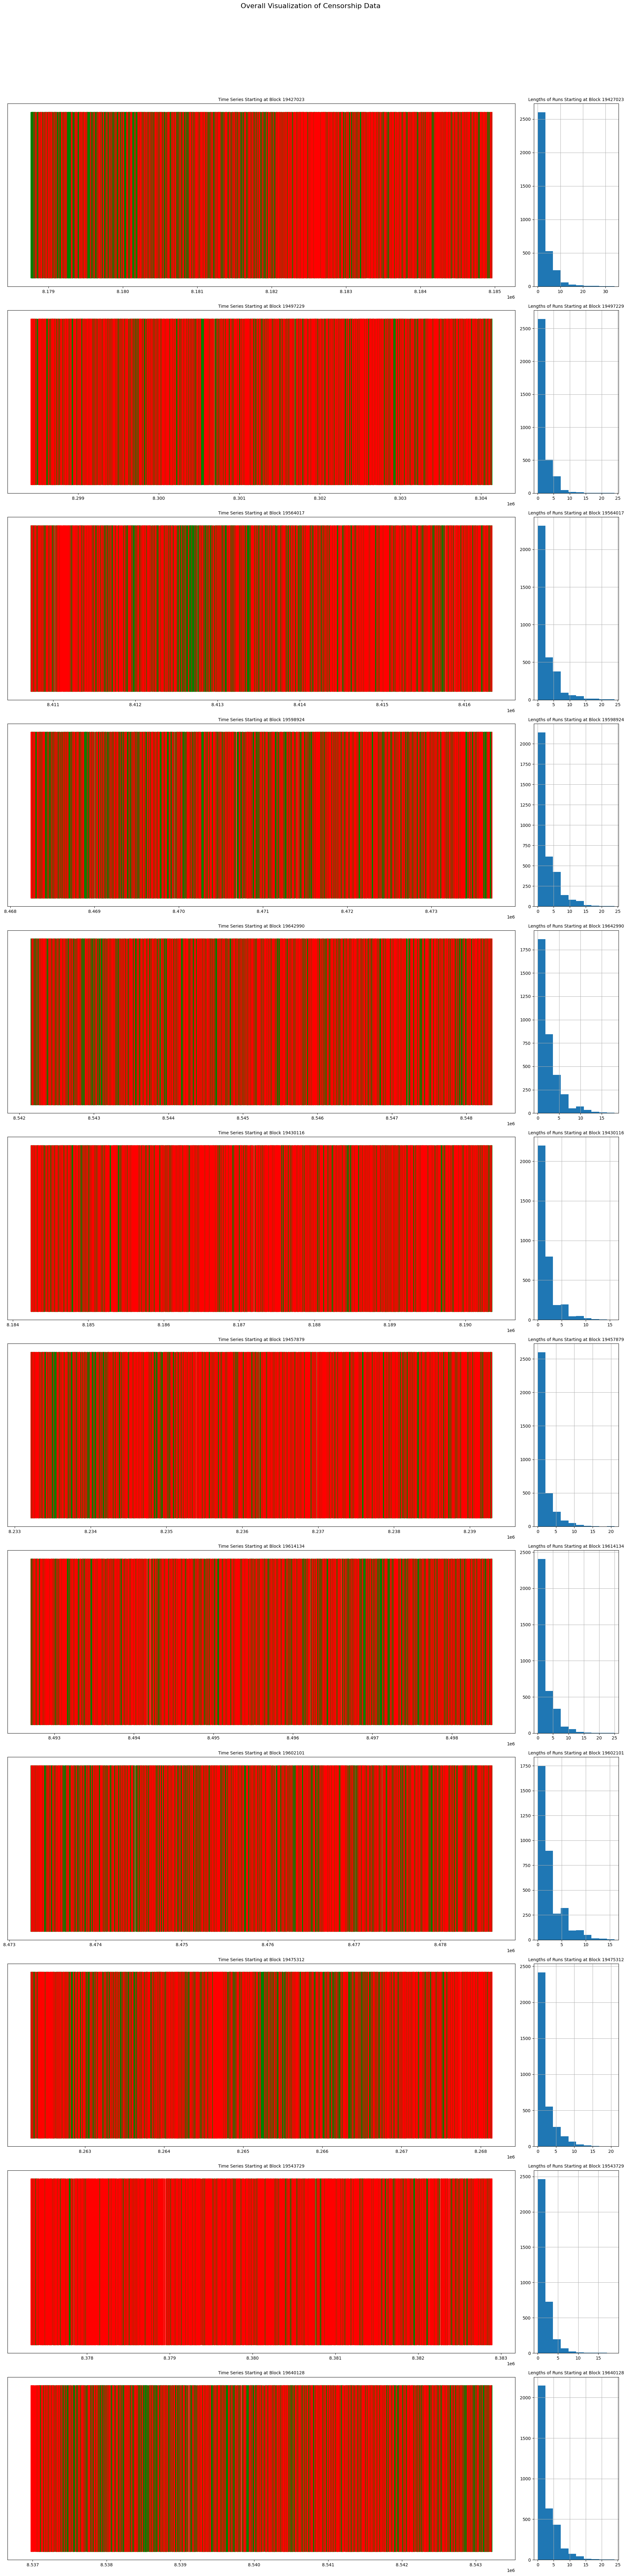

In [6]:
# Create a subplot grid
fig, axs = plt.subplots(len(BLOCK_NUMBERS_TO_USE), 2, gridspec_kw={'width_ratios': [6, 1]}, figsize=(20, 7 * len(BLOCK_NUMBERS_TO_USE)))

for idx, block_number in enumerate(BLOCK_NUMBERS_TO_USE):
    start_value = block_number
    mask = (data_to_use['block_number'] >= start_value) & (data_to_use['block_number'] < start_value + N_timesteps * SAFETY_MARGIN)
    censor_series = data_to_use[mask]['is_builder_censor']

    # Creating time series
    # Approach suggested by https://stackoverflow.com/questions/44951911/plot-a-binary-timeline-in-matplotlib

    # Creating the binary time series plot on the first column using broken_barh
    censor_series_ones = censor_series[censor_series == 1]
    times_ones = [(index, 1) for index in censor_series_ones.index]
    axs[idx, 0].broken_barh(times_ones, (-1, 2), color="green", label='No Censor')

    censor_series_zeros = censor_series[censor_series == 0]
    times_zeros = [(index, 1) for index in censor_series_zeros.index]
    axs[idx, 0].broken_barh(times_zeros, (-1, 2), color="red", label='Censor')
    axs[idx, 0].set_yticks([])
 #   axs[idx, 0].set_xticks(range(0, len(censor_series), max(1, len(censor_series)//5)))  # Adjust as needed
    axs[idx, 0].set_title(f"Time Series Starting at Block {block_number}", fontsize=10)

    # Create histogram showing distribution of runs.
    # Code for finding consecutive runs from https://stackoverflow.com/questions/27626542/counting-consecutive-positive-values-in-python-pandas-array
    censor_series_ones_runs = censor_series * (censor_series.groupby(
                                (censor_series != censor_series.shift()).cumsum()
                                ).cumcount() + 1)
    censor_series_ones_runs.hist(ax=axs[idx, 1])
    axs[idx, 1].set_title(f"Lengths of Runs Starting at Block {block_number}", fontsize=10)

# Set a title for the entire figure
fig.suptitle('Overall Visualization of Censorship Data', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to make space for the suptitle
plt.show()


# Some tests for sanity checking 

In [7]:
# Determining total proportion from list
data_to_use['is_builder_censor'].mean()

0.6389587109904106

In [8]:
data_to_use['is_builder_censor'].head(-1_000).mean()

0.6392865111939037

In [9]:
data_to_use['is_builder_censor'].autocorr(lag = 1)

0.005782983694630541

In [10]:
data_to_use['is_builder_censor'].head(-1_000).autocorr(lag = 1)

0.005135274879154034

## Analysis of Simulation Results

In [11]:
# Swapping out data from different runs can be done here directly, or by duplicating the notebook per run for comparability. 

local_sim_data_path = '../data/simulations/may7_final_trajectory_tensor.csv.zip'
if os.path.isfile(local_sim_data_path):
    print("Reading from local data.")
    FILENAME = local_sim_data_path
else:
    print("Reading from cloud.")
    timestamp = '2024-05-08T000051Z'
    FILENAME = f"s3://aztec-gddt/psuu_run_{timestamp}/trajectory_tensor.csv.zip"
    
sim_df = pd.read_csv(FILENAME, compression='zip')

Reading from local data.


In [12]:
PHASES = ["proposal", "reveal", "commit_bond", "rollup", "race"]
for phase in PHASES:
    min_col = f'phase_duration_{phase}_min_blocks'
    max_col = f'phase_duration_{phase}_max_blocks'
    sim_df[f'{phase}_is_fixed'] = (sim_df[min_col] == sim_df[max_col])

In [13]:
# (Optional) Drop less relevant columns for ease of use.

sim_df.drop(columns = ['run', 'subset', 'simulation',
       'daily_block_reward',  'proportion_slashed_prover',
       'proportion_slashed_sequencer', 
       'average_duration_finalized_blocks', 'average_duration_nonfinalized_blocks',
       'stddev_duration_finalized_blocks', 'stddev_duration_nonfinalized_blocks',
       'delta_total_revenue_agents'], inplace = True)

In [14]:
sim_df.drop(columns=["Unnamed: 0", "index"]).describe().T

,count,mean,std,min,25%,50%,75%,max
phase_duration_proposal_min_blocks,128000.0,1.500000,1.500006,0.0,0.000000,1.500000,3.000000,3.000000
phase_duration_proposal_max_blocks,128000.0,7.500000,4.500018,3.0,3.000000,7.500000,12.000000,12.000000
phase_duration_reveal_min_blocks,128000.0,6.750000,10.034355,0.0,0.000000,1.500000,8.250000,24.000000
phase_duration_reveal_max_blocks,128000.0,13.500000,10.500041,3.0,3.000000,13.500000,24.000000,24.000000
phase_duration_commit_bond_min_blocks,128000.0,3.750000,4.918098,0.0,0.000000,1.500000,5.250000,12.000000
phase_duration_commit_bond_max_blocks,128000.0,7.500000,4.500018,3.0,3.000000,7.500000,12.000000,12.000000
phase_duration_rollup_min_blocks,128000.0,23.750000,33.048389,0.0,0.000000,7.500000,31.250000,80.000000
phase_duration_rollup_max_blocks,128000.0,47.500000,32.500127,15.0,15.000000,47.500000,80.000000,80.000000
phase_duration_race_min_blocks,128000.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
phase_duration_race_max_blocks,128000.0,6.000000,0.000000,6.0,6.000000,6.000000,6.000000,6.000000


# Some basic Statistics about the effect of phase durations on the proportion of Race Mode and skipped blocks

In [15]:
# Checking some basic stats for intuition about all runs where race mode proportion was under a certain threshold. 

filtered_df = sim_df[(sim_df['proportion_race_mode'] < 0.1)]

list = ['phase_duration_proposal_min_blocks',
       'phase_duration_proposal_max_blocks',
       'phase_duration_reveal_min_blocks', 'phase_duration_reveal_max_blocks',
       'phase_duration_commit_bond_min_blocks',
       'phase_duration_commit_bond_max_blocks',
       'phase_duration_rollup_min_blocks', 'phase_duration_rollup_max_blocks',
       'phase_duration_race_min_blocks', 'phase_duration_race_max_blocks',
       'proportion_race_mode', 'proportion_skipped']

for el in list: 
    median_duration = filtered_df[el].median() 
    average_duration = filtered_df[el].mean()
    print(el + ' has a median value of ' + str(median_duration) + ' and a mean value of ' + str(average_duration))

phase_duration_proposal_min_blocks has a median value of 0.0 and a mean value of 1.4639175257731958
phase_duration_proposal_max_blocks has a median value of 3.0 and a mean value of 7.11340206185567
phase_duration_reveal_min_blocks has a median value of 0.0 and a mean value of 10.639175257731958
phase_duration_reveal_max_blocks has a median value of 24.0 and a mean value of 22.84536082474227
phase_duration_commit_bond_min_blocks has a median value of 0.0 and a mean value of 5.051546391752577
phase_duration_commit_bond_max_blocks has a median value of 12.0 and a mean value of 11.31958762886598
phase_duration_rollup_min_blocks has a median value of 15.0 and a mean value of 36.47766323024055
phase_duration_rollup_max_blocks has a median value of 80.0 and a mean value of 71.73539518900344
phase_duration_race_min_blocks has a median value of 0.0 and a mean value of 0.0
phase_duration_race_max_blocks has a median value of 6.0 and a mean value of 6.0
proportion_race_mode has a median value of 

In [16]:
# Constructing the parameter combinations to retrieve their specific outcomes. 

from cadCAD.tools.preparation import sweep_cartesian_product

sweep_params = {'phase_duration_proposal_max_blocks' : [3, 12] ,
  'phase_duration_reveal_max_blocks' : [3, 24] ,
  'phase_duration_commit_bond_max_blocks' : [3, 12] ,
  'phase_duration_rollup_max_blocks' : [15, 80]
 }

list_of_params = sweep_cartesian_product(sweep_params)
#print(list_of_params)

# Determine the length of the lists
list_length = len(next(iter(list_of_params.values())))  # Safer method for getting length

# Create a dictionary to hold the criteria in the correct format for calculate_means
criteria_dict = {}
for i in range(list_length):
    # Extract the ith element from each list and form a new dictionary for criteria
    criteria_dict[f"Combination {i+1}"] = {key: value[i]
                                        for key, value in list_of_params.items()}

# Print the criteria dictionaries in the format ready for calculate_means
for description, criteria in criteria_dict.items():
    print(f"{description}: {criteria}")

c:\Users\andre\Desktop\aztec-gddt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Combination 1: {'phase_duration_proposal_max_blocks': 3, 'phase_duration_reveal_max_blocks': 3, 'phase_duration_commit_bond_max_blocks': 3, 'phase_duration_rollup_max_blocks': 15}
Combination 2: {'phase_duration_proposal_max_blocks': 3, 'phase_duration_reveal_max_blocks': 3, 'phase_duration_commit_bond_max_blocks': 3, 'phase_duration_rollup_max_blocks': 80}
Combination 3: {'phase_duration_proposal_max_blocks': 3, 'phase_duration_reveal_max_blocks': 3, 'phase_duration_commit_bond_max_blocks': 12, 'phase_duration_rollup_max_blocks': 15}
Combination 4: {'phase_duration_proposal_max_blocks': 3, 'phase_duration_reveal_max_blocks': 3, 'phase_duration_commit_bond_max_blocks': 12, 'phase_duration_rollup_max_blocks': 80}
Combination 5: {'phase_duration_proposal_max_blocks': 3, 'phase_duration_reveal_max_blocks': 24, 'phase_duration_commit_bond_max_blocks': 3, 'phase_duration_rollup_max_blocks': 15}
Combination 6: {'phase_duration_proposal_max_blocks': 3, 'phase_duration_reveal_max_blocks': 24, 

Combination 1: Durations of: 3, 3, 3, 15 results in a mean value of proportion_race_mode: 0.48, proportion_skipped: 0.26, for a total of: 0.74 irregular blocks
Combination 2: Durations of: 3, 3, 3, 80 results in a mean value of proportion_race_mode: 0.47, proportion_skipped: 0.26, for a total of: 0.73 irregular blocks
Combination 3: Durations of: 3, 3, 12, 15 results in a mean value of proportion_race_mode: 0.41, proportion_skipped: 0.28, for a total of: 0.69 irregular blocks
Combination 4: Durations of: 3, 3, 12, 80 results in a mean value of proportion_race_mode: 0.41, proportion_skipped: 0.27, for a total of: 0.68 irregular blocks
Combination 5: Durations of: 3, 24, 3, 15 results in a mean value of proportion_race_mode: 0.41, proportion_skipped: 0.28, for a total of: 0.69 irregular blocks
Combination 6: Durations of: 3, 24, 3, 80 results in a mean value of proportion_race_mode: 0.40, proportion_skipped: 0.27, for a total of: 0.67 irregular blocks
Combination 7: Durations of: 3, 24, 

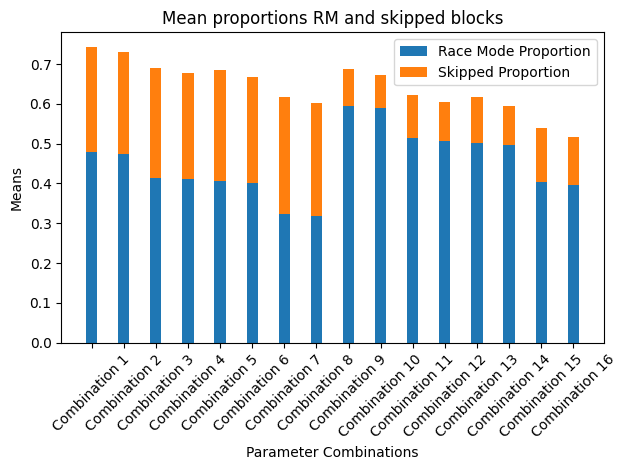

In [17]:
# Basic stats about each parameter combination

criteria_dict = {}
for i in range(list_length):
    # Extract the ith element from each list and form a new dictionary for criteria
    criteria_dict[f"Combination {i+1}"] = {key: value[i]
                                        for key, value in list_of_params.items()}


def calculate_means(df, filter_criteria, columns_to_average):
    results = []
    # Loop through each set of criteria in the filter_criteria dictionary
    for description, conditions in filter_criteria.items():
        # Construct the query string based on the conditions
        query = ' & '.join(
            [f"{col} == {val}" for col, val in conditions.items()])
        # Apply the query to filter the DataFrame
        filtered_df = df.query(query)
        # Calculate mean for each specified column and store the result with a description
        means = {column: filtered_df[column].mean()
                 for column in columns_to_average}
        # Also return the conditions used for reference in the print statement
        results.append((description, conditions, means))

    return results

# Columns to average
columns_to_average = ['proportion_race_mode', 'proportion_skipped']

# Calculate means based on criteria
results = calculate_means(sim_df, criteria_dict, columns_to_average)

# Print results with individual values per parameter combination
for description, conditions, mean_values in results:
    conditions_values = ', '.join([str(value)
                                  for value in conditions.values()])
    mean_results = ', '.join(
        [f"{key}: {value:.2f}" for key, value in mean_values.items()])
    # Calculate the sum of means to see total of skipped and race_mode
    sum_of_means = sum(mean_values.values())
    print(f"{description}: Durations of: {conditions_values} results in a mean value of {mean_results}, for a total of: {sum_of_means:.2f} irregular blocks")

# Simple Bar Chart setup 
combination_labels = []
race_mode_means = []
skipped_means = []

for description, _, mean_values in results:
    combination_labels.append(description)
    race_mode_means.append(mean_values['proportion_race_mode'])
    skipped_means.append(mean_values['proportion_skipped'])

fig, ax = plt.subplots()
width = 0.35  

# Bars for race_mode
ax.bar(combination_labels, race_mode_means,
       width, label='Race Mode Proportion')

# Bars for skipped stacked on top 
ax.bar(combination_labels, skipped_means, width,
       bottom=race_mode_means, label='Skipped Proportion')

ax.set_xlabel('Parameter Combinations')
ax.set_ylabel('Means')
ax.set_title('Mean proportions RM and skipped blocks')
ax.legend()

plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

As one can see, stringent censorship resulted in 60-80% of blocks either skipped, or in Race Mode throughout all parameter combinations. 
For runs with a short proposal phase, the proportion of skipped blocks was raised dramatically, while longer proposal phases instead led to failure during the later phases. 

Combination 1: Durations of: 3, 3, 3, 15 results in a median value of proportion_race_mode: 0.48, proportion_skipped: 0.26, for a total of: 0.75 irregular blocks
Combination 2: Durations of: 3, 3, 3, 80 results in a median value of proportion_race_mode: 0.48, proportion_skipped: 0.26, for a total of: 0.74 irregular blocks
Combination 3: Durations of: 3, 3, 12, 15 results in a median value of proportion_race_mode: 0.42, proportion_skipped: 0.28, for a total of: 0.69 irregular blocks
Combination 4: Durations of: 3, 3, 12, 80 results in a median value of proportion_race_mode: 0.42, proportion_skipped: 0.26, for a total of: 0.68 irregular blocks
Combination 5: Durations of: 3, 24, 3, 15 results in a median value of proportion_race_mode: 0.41, proportion_skipped: 0.28, for a total of: 0.69 irregular blocks
Combination 6: Durations of: 3, 24, 3, 80 results in a median value of proportion_race_mode: 0.41, proportion_skipped: 0.27, for a total of: 0.67 irregular blocks
Combination 7: Durations

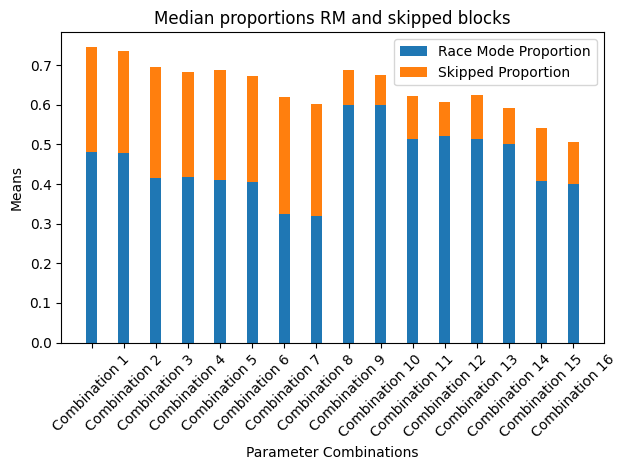

In [18]:
# Basic statistics about each parameter combination

criteria_dict = {}
for i in range(list_length):
    # Extract the ith element from each list and form a new dictionary for criteria
    criteria_dict[f"Combination {i+1}"] = {key: value[i]
                                           for key, value in list_of_params.items()}


def calculate_median(df, filter_criteria, columns_to_average):
    results = []
    # Loop through each set of criteria in the filter_criteria dictionary
    for description, conditions in filter_criteria.items():
        # Construct the query string based on the conditions
        query = ' & '.join(
            [f"{col} == {val}" for col, val in conditions.items()])
        # Apply the query to filter the DataFrame
        filtered_df = df.query(query)
        # Calculate median for each specified column and store the result with a description
        medians = {column: filtered_df[column].median()
                 for column in columns_to_average}
        # Also return the conditions used for reference in the print statement
        results.append((description, conditions, medians))

    return results


# Columns to average
columns_to_average = ['proportion_race_mode', 'proportion_skipped']

# Calculate means based on criteria
results = calculate_median(sim_df, criteria_dict, columns_to_average)

# Print results with individual values per parameter combination
for description, conditions, median_values in results:
    conditions_values = ', '.join([str(value)
                                  for value in conditions.values()])
    median_results = ', '.join(
        [f"{key}: {value:.2f}" for key, value in median_values.items()])
    # Calculate the sum of means to see total of skipped and race_mode
    sum_of_medians = sum(median_values.values())
    print(f"{description}: Durations of: {conditions_values} results in a median value of {median_results}, for a total of: {sum_of_medians:.2f} irregular blocks")

# Simple Bar Chart setup
combination_labels = []
race_mode_medians = []
skipped_medians = []

for description, _, median_values in results:
    combination_labels.append(description)
    race_mode_medians.append(median_values['proportion_race_mode'])
    skipped_medians.append(median_values['proportion_skipped'])

fig, ax = plt.subplots()
width = 0.35

# Bars for race_mode
ax.bar(combination_labels, race_mode_medians,
       width, label='Race Mode Proportion')

# Bars for skipped stacked on top
ax.bar(combination_labels, skipped_medians, width,
       bottom=race_mode_medians, label='Skipped Proportion')

ax.set_xlabel('Parameter Combinations')
ax.set_ylabel('Means')
ax.set_title('Median proportions RM and skipped blocks')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mutual Information
[Mutual Information](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py) can be thought of as a generalization of the correlation coefficient or F-test, tracking the strength of relationships that aren't necessarily linear.

In the code below, we 
* calculate the mutual information between each potential parameter and the KPI.
* drop any parameters which have negligible mutual information with KPI.
* plot a heatmap of the remaining relationship.

This gives insight into which variables are most impactful on the KPIs.

In [19]:
from sklearn.feature_selection import mutual_info_regression

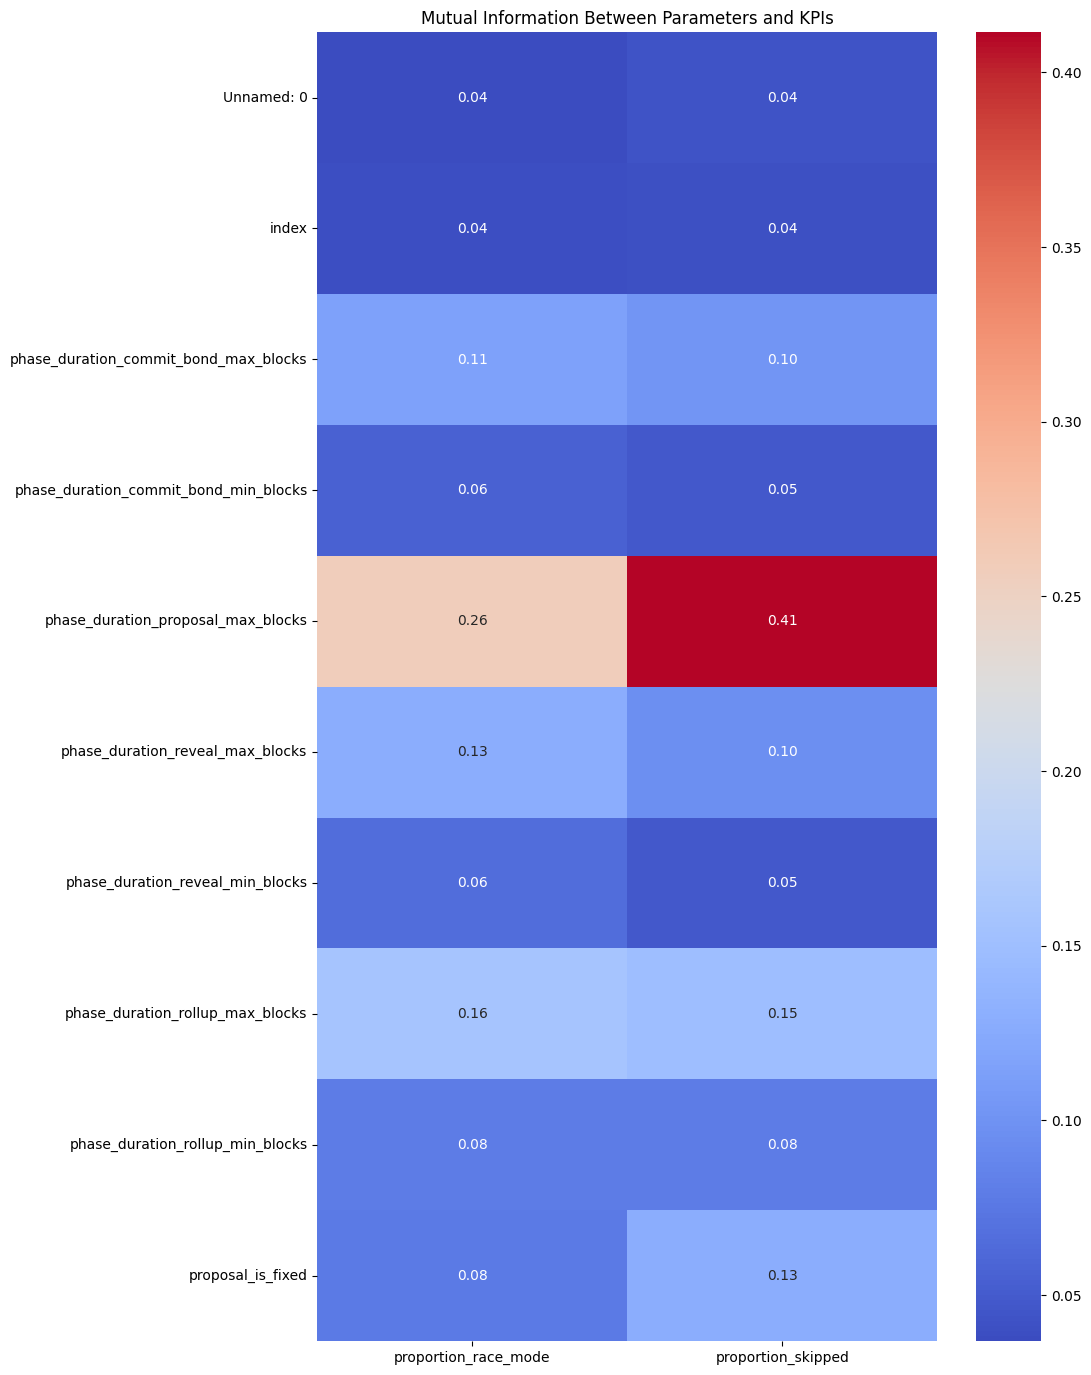

In [20]:
kpis = ['proportion_race_mode', 
        'proportion_skipped']

    
features = sim_df.columns.difference(kpis)  # All columns except kpis

# Calculate mutual information for each target and store in a DataFrame
mi_results = pd.DataFrame(index=features)

for kpi in kpis:
    mi_scores = mutual_info_regression(sim_df[features], sim_df[kpi])
    mi_results[kpi] = mi_scores


all_zero_rows = (mi_results < 0.01).all(axis = 1)
mi_results = mi_results[~all_zero_rows]

# Plotting
plt.figure(figsize=(10, len(features)))  # Adjust size as needed
sns.heatmap(mi_results, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mutual Information Between Parameters and KPIs')
plt.show()

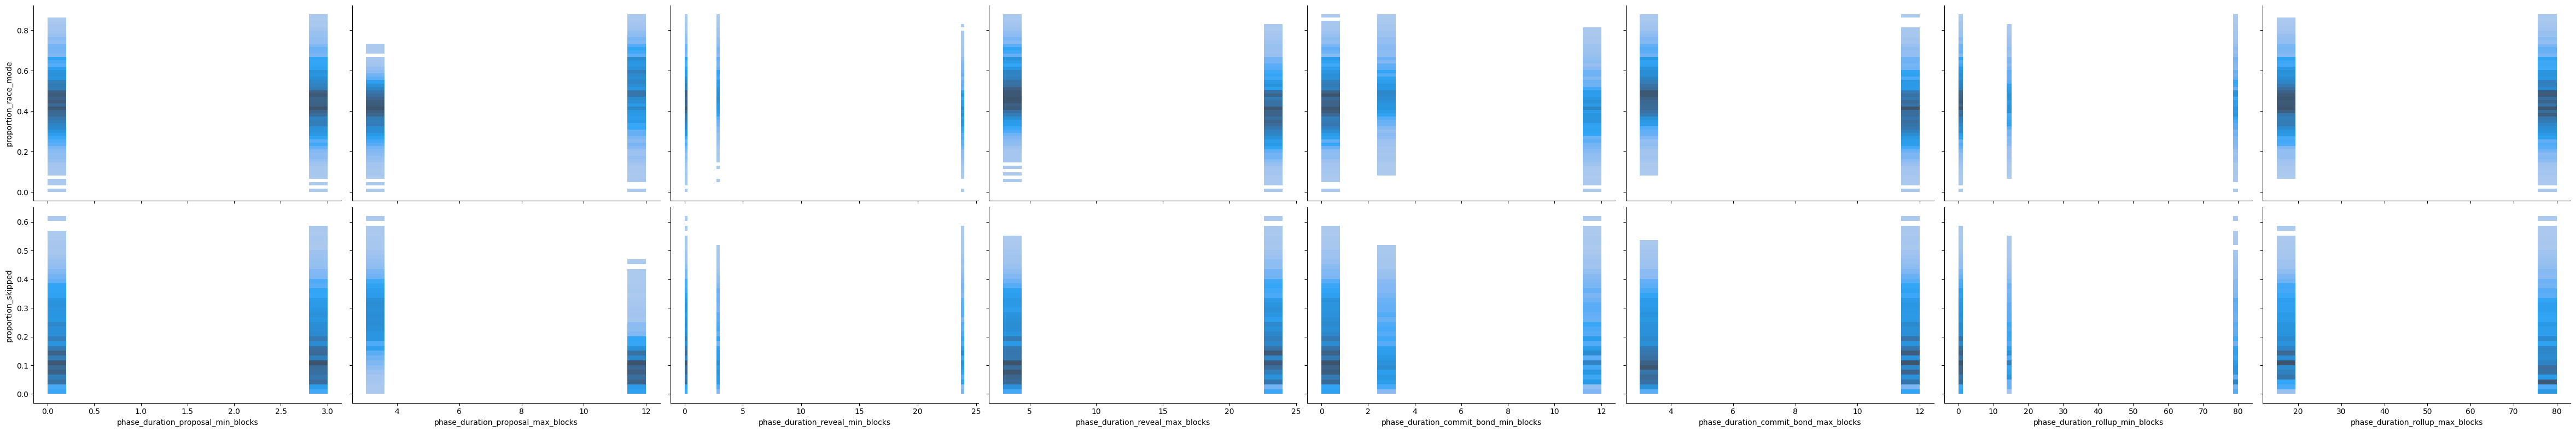

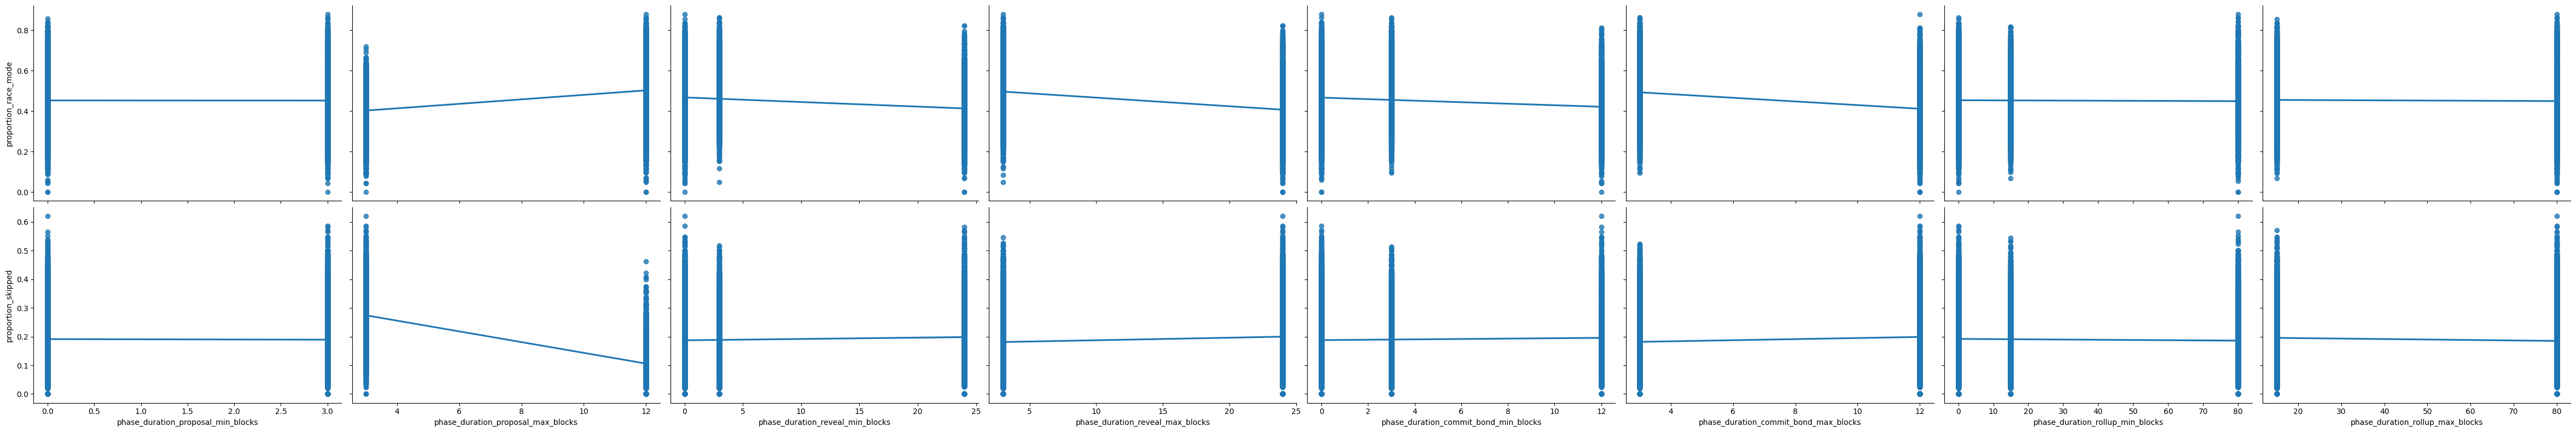

In [21]:
import seaborn as sns

fig_df = sim_df.copy().sample(10_000)

GOVERNANCE_SURFACE_PARAMS = ['phase_duration_proposal_min_blocks',
       'phase_duration_proposal_max_blocks',
       'phase_duration_reveal_min_blocks',
        'phase_duration_reveal_max_blocks',
       'phase_duration_commit_bond_min_blocks',
       'phase_duration_commit_bond_max_blocks',
       'phase_duration_rollup_min_blocks',
        'phase_duration_rollup_max_blocks']

KPIs = ['proportion_race_mode', 'proportion_skipped']

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPIs)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

g1 = sns.pairplot(data=fig_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=KPIs,
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


g2 = sns.pairplot(data=fig_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=KPIs,
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')

plt.show()